### Importações e Instalações

In [1]:
import torch
import random
import splitfolders
import shutil
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Dividindo os Ddaos

In [3]:
splitfolders.ratio('data',
                   output = 'dados',
                   seed = 42,
                   ratio = (.7, .2, .1),
                   group_prefix = None,
                   move = False)

### Aplicando as Transformações nas Imagens

In [4]:
transformacoes_treino = transforms.Compose([transforms.Resize(size = (256, 256)),
                                            transforms.RandomHorizontalFlip(),
                                            transforms.RandomVerticalFlip(),
                                            transforms.GaussianBlur(kernel_size = (3, 7), sigma = (0.1, 2)),
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                                                 std = [0.229, 0.224, 0.225])])

In [5]:
transformacoes_valid = transforms.Compose([transforms.Resize(size = (256, 256)),
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                                                 std = [0.229, 0.224, 0.225])])

In [6]:
transformacoes_teste = transforms.Compose([transforms.Resize(size = (256, 256)),
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                                                 std = [0.229, 0.224, 0.225])])

In [7]:
transformacoes_all = transforms.Compose([transforms.Resize(size = (256, 256)),
                                         transforms.ToTensor()])

### Carregando as Imagens em Estruturas de Dados

In [8]:
dados_treino = datasets.ImageFolder(root = 'dados/train', transform = transformacoes_treino)

In [9]:
dados_valid = datasets.ImageFolder(root = 'dados/test', transform = transformacoes_valid)

In [10]:
dados_teste = datasets.ImageFolder(root = 'dados/test', transform = transformacoes_teste)

In [11]:
data = datasets.ImageFolder(root = 'data', transform = transformacoes_all)

In [12]:
print(f'Dataset Labels: {dados_treino.class_to_idx} \n')

Dataset Labels: {'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3} 



In [13]:
for name, dataset in zip(['Treino', 'Validacao', 'Teste'], [dados_treino, dados_valid, dados_teste]):
    images_per_class = pd.Series(dataset.targets).value_counts()
    print(f'Imagens por classes em {name}:')
    print(images_per_class, '\n')

Imagens por classes em Treino:
1    914
3    813
0    802
2    401
Name: count, dtype: int64 

Imagens por classes em Validacao:
1    131
3    117
0    115
2     59
Name: count, dtype: int64 

Imagens por classes em Teste:
1    131
3    117
0    115
2     59
Name: count, dtype: int64 



### Visualizando as Imagens

In [14]:
labels_for_viz = {v: k for k, v in data.class_to_idx.items()}

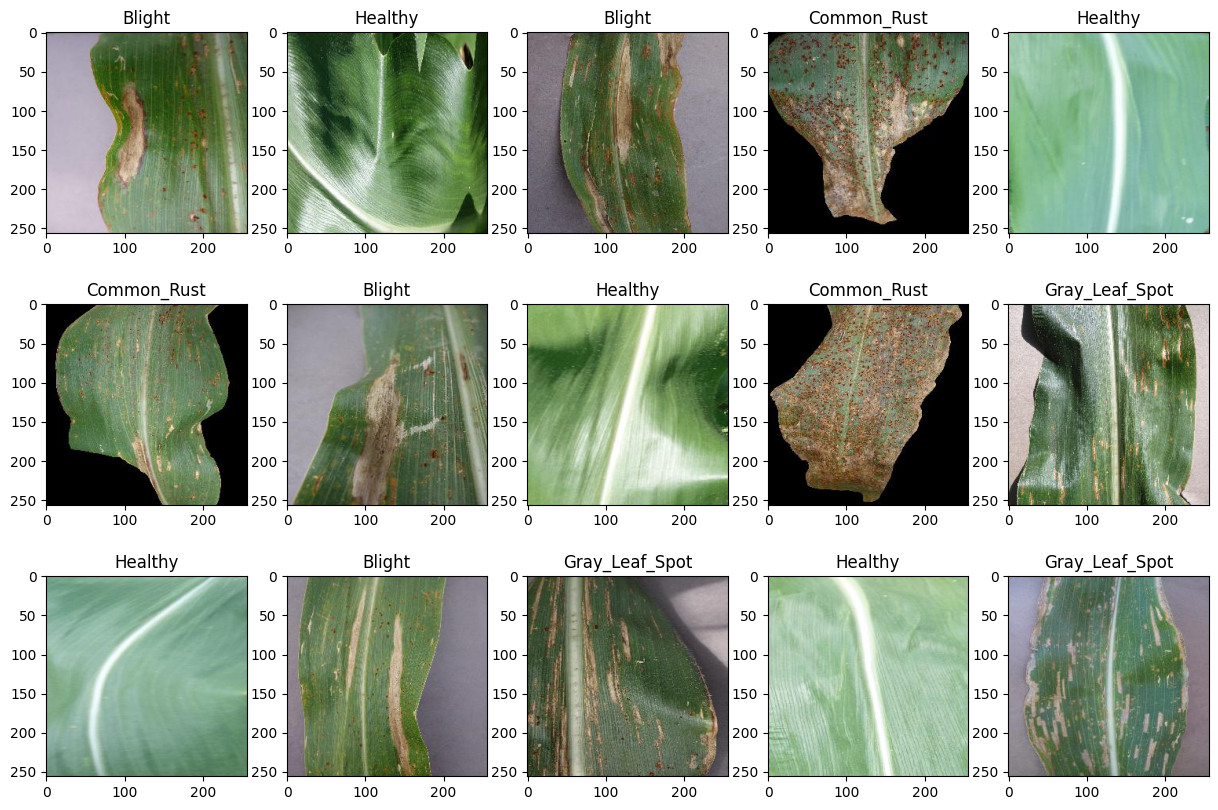

In [15]:
fig, ax = plt.subplots(3, 5, figsize = (15, 10))
ax = ax.flatten()
for i in range(15):
    sample = random.randint(0, len(data))
    ax[i].imshow(data[sample][0].permute(1, 2, 0))
    ax[i].title.set_text(labels_for_viz[data[sample][1]])

### Criação dos Data Loaders

In [16]:
dl_treino = DataLoader(dataset = dados_treino, batch_size = 32, num_workers = 2, shuffle = True)

In [17]:
dl_val = DataLoader(dataset = dados_valid, batch_size = 32, num_workers = 2, shuffle = True)

In [18]:
dl_teste = DataLoader(dataset = dados_teste, batch_size = 32, num_workers = 2, shuffle = False)

In [19]:
img, label = next(iter(dl_treino))
print(f'Batch e Image Shape:{img.shape}--> [batch_size, color_channels, height, width]')
print(f'\n Labels: {label}')

Batch e Image Shape:torch.Size([32, 3, 256, 256])--> [batch_size, color_channels, height, width]

 Labels: tensor([3, 3, 0, 2, 1, 0, 2, 3, 1, 0, 1, 3, 3, 1, 1, 2, 1, 2, 3, 0, 3, 3, 3, 0,
        0, 2, 0, 1, 3, 0, 0, 1])


### Construção do Modelo

In [20]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = 131072, out_features = 32),
            nn.ReLU(),
            nn.Linear(in_features = 32, out_features = 16),
            nn.ReLU(),
            nn.Linear(in_features = 16, out_features = 4)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.fc(x)
        return x

In [33]:
modelo = NeuralNetwork()
modelo.to(device)

NeuralNetwork(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=131072, out_features=32, bias=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Linear(in_features=16, out_features=4, bias=True)
  )
)

### Definindo Hiperparâmetros, Função de Erro e Otimizador

In [35]:
taxa_aprendizagem = 10e-3
numero_epochs = 15

In [36]:
loss_fn = nn.CrossEntropyLoss()

In [37]:
optimizer = torch.optim.SGD(modelo.parameters(), lr = taxa_aprendizagem)

### Criando o Loop de Treino

In [38]:
def treina_modelo(num_epochs):

    val_best_accuracy = 0.0
    train_loss_history = []
    val_loss_history = []
    train_accuracy_history = []
    val_accuracy_history = []

    for epoch in range(1, num_epochs + 1):

        running_train_loss = 0.0
        running_train_accuracy = 0.0
        train_total = 0
        running_val_accuracy = 0.0
        running_val_loss = 0.0
        val_total = 0

        for data in dl_treino:
            inputs, outputs = data
            inputs, outputs = inputs.to(device), outputs.to(device)
            optimizer.zero_grad()
            predictions = modelo(inputs)
            train_loss = loss_fn(predictions, outputs)
            _, train_predicted = torch.max(predictions, 1)
            running_train_accuracy += (train_predicted == outputs).sum().item()
            train_total += outputs.size(0)
            train_loss.backward()
            optimizer.step()
            running_train_loss += train_loss.item()

        train_loss_value = running_train_loss / len(dl_treino)
        train_loss_history.append(train_loss_value)
        train_accuracy = (100 * running_train_accuracy) / train_total
        train_accuracy_history.append(train_accuracy)

        with torch.no_grad():
    
            modelo.eval()
    
            for data in dl_val:
                inputs, outputs = data
                inputs, outputs = inputs.to(device), outputs.to(device)
                predictions = modelo(inputs)
                val_loss = loss_fn(predictions, outputs)
                _, val_predicted = torch.max(predictions, 1)
                running_val_loss += val_loss.item()
                val_total += outputs.size(0)
                running_val_accuracy += (val_predicted == outputs).sum().item()

        val_loss_value = running_val_loss/len(dl_val)
        val_loss_history.append(val_loss_value)
        val_accuracy = (100 * running_val_accuracy)/val_total
        val_accuracy_history.append(val_accuracy)

        if val_accuracy > val_best_accuracy:
            torch.save(modelo.state_dict(), "modelo.pth")
            val_best_accuracy = val_accuracy

        print(f'Epoch: {epoch}'
              f'- Training accuracy: {train_accuracy}'
              f'- Validation accuracy: {val_accuracy}'
              f'- Training error: {train_loss_value}'
              f'- Validation error: {val_loss_value}')
        
    print('\ntreinamento Cooncluído!\n')

    return train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history

### Criando o Loop de Teste do Modelo

In [39]:
def testa_modelo():
    
    path = 'modelo.pth'
    modelo.load_state_dict(torch.load(path))
    modelo.eval()
    running_accuracy = 0
    total = 0
    all_predictions = []

    with torch.no_grad():

        for data in dl_teste:

            inputs, outputs = data
            inputs, outputs = inputs.to(device), outputs.to(device)
            outputs = outputs.to(torch.float32)
            predictions = modelo(inputs)
            _, predicted = torch.max(predictions, 1)
            total += outputs.size(0)
            running_accuracy += (predicted == outputs).sum().item()
            accuracy = 100 * running_accuracy/total
            all_predictions.append(list(predicted.to('cpu').numpy()))

        print(f'Acurácia em Teste: {accuracy}')

    return np.hstack(all_predictions)

### Treinamento do Modelo

In [40]:
%%time
train_accuuracy_history, val_accuracy_history, train_loss_history, val_loss_history = treina_modelo(numero_epochs)

Epoch: 1- Training accuracy: 69.65870307167235- Validation accuracy: 67.53554502369668- Training error: 0.7749633646529653- Validation error: 0.8106727642672402
Epoch: 2- Training accuracy: 78.08873720136519- Validation accuracy: 75.82938388625593- Training error: 0.5543786326180333- Validation error: 0.568779068333762
Epoch: 3- Training accuracy: 80.68259385665529- Validation accuracy: 79.14691943127963- Training error: 0.4764555082049059- Validation error: 0.5488871144396918
Epoch: 4- Training accuracy: 82.66211604095564- Validation accuracy: 77.25118483412322- Training error: 0.4270731818092906- Validation error: 0.5761581584811211
Epoch: 5- Training accuracy: 82.96928327645051- Validation accuracy: 81.51658767772511- Training error: 0.41080916494778963- Validation error: 0.44155600533953737
Epoch: 6- Training accuracy: 84.1296928327645- Validation accuracy: 78.19905213270142- Training error: 0.38460264938033145- Validation error: 0.6063842581851142
Epoch: 7- Training accuracy: 84.6

### Avaliando o Modelo

In [41]:
previsoes = testa_modelo()

Acurácia em Teste: 87.67772511848341


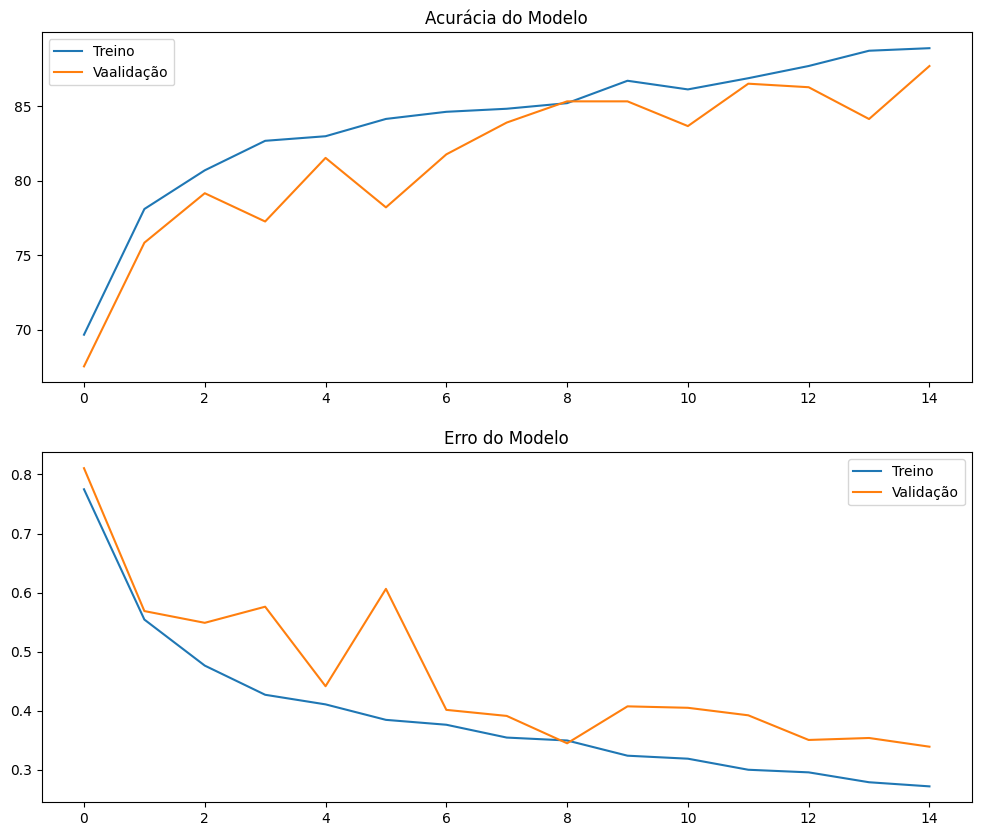

In [48]:
fig, ax = plt.subplots(2, 1, figsize = (12, 10))
ax = ax.flatten()

ax[0].plot(train_accuuracy_history, label = 'Treino')
ax[0].plot(val_accuracy_history, label = 'Vaalidação')
ax[0].title.set_text('Acurácia do Modelo')
ax[0].legend()

ax[1].plot(train_loss_history, label = 'Treino')
ax[1].plot(val_loss_history, label = 'Validação')
ax[1].title.set_text('Erro do Modelo')
ax[1].legend()

plt.show()

In [50]:
print(classification_report(dados_teste.targets, previsoes))

              precision    recall  f1-score   support

           0       0.77      0.94      0.84       115
           1       0.89      0.95      0.92       131
           2       0.88      0.39      0.54        59
           3       1.00      0.98      0.99       117

    accuracy                           0.88       422
   macro avg       0.88      0.81      0.82       422
weighted avg       0.88      0.88      0.86       422



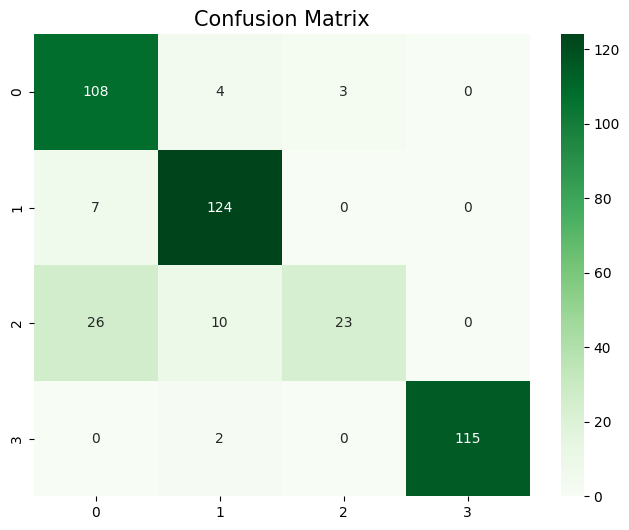

In [51]:
plt.figure(figsize = (8, 6))
sns.heatmap(confusion_matrix(dados_teste.targets, previsoes),
            cmap = 'Greens',
            annot = True,
            fmt = 'd')
plt.title('Confusion Matrix', size = 15)
plt.show()

### Previsões com Novos Dados

In [53]:
previsao = modelo.forward((dados_teste[-2][0]).to(device).unsqueeze(0))

In [54]:
print(previsao)

tensor([[-5.6133, -1.6861, -2.9470,  5.6583]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


In [55]:
previsao = int(torch.max(previsao, 1)[1])
print(f'Classe Prevista: {labels_for_viz[previsao]}')

Classe Prevista: Healthy


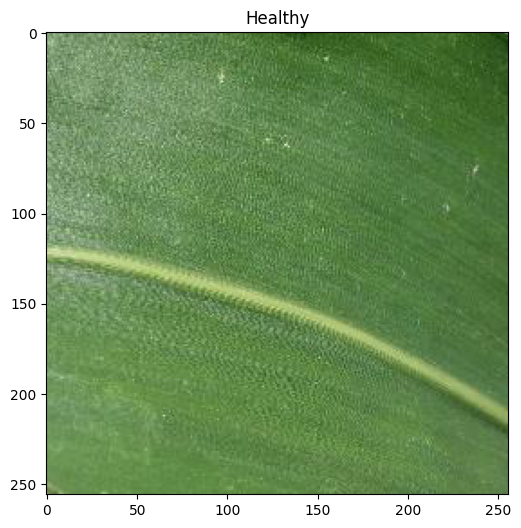

In [56]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
ax.imshow(data[-2][0].permute(1, 2, 0))
ax.title.set_text(f'{labels_for_viz[data[-2][1]]}')
plt.show()